In [1]:
import cv2
import imutils
import pytesseract
from matplotlib import pyplot as plt
import numpy as np

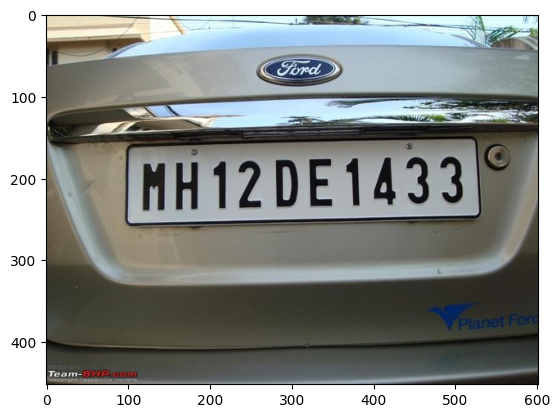

In [2]:
image = cv2.imread('license2.jpeg')
plt.imshow(image)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

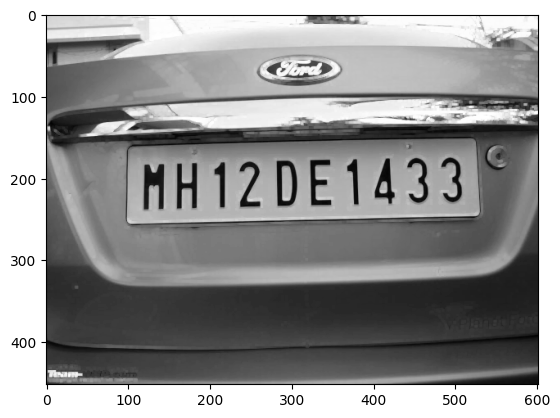

In [3]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = cv2.dilate(gray_image,np.ones((3,3)))
plt.imshow(gray_image,cmap='gray')

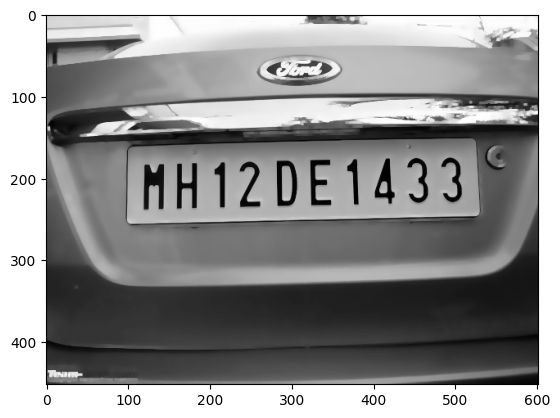

In [4]:
gray_image = cv2.bilateralFilter(gray_image, 11, 17, 17) 
plt.imshow(gray_image,cmap='gray')

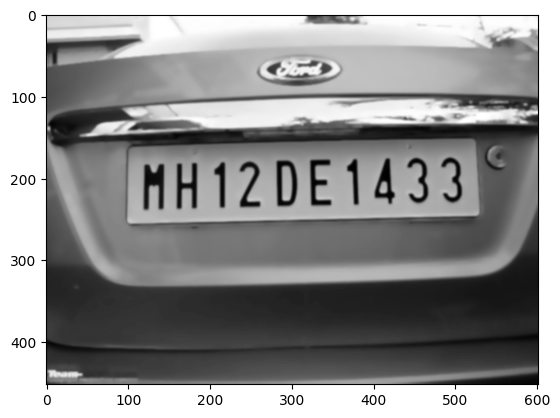

In [5]:
gray_image = cv2.GaussianBlur(gray_image,(5,5),0)
plt.imshow(gray_image,cmap='gray')

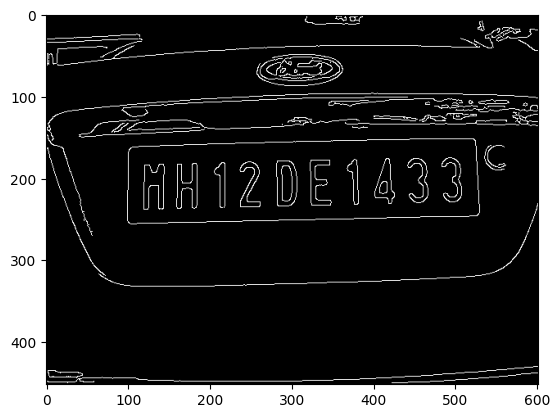

In [6]:
edged = cv2.Canny(gray_image, 30, 200)
plt.imshow(edged,cmap='gray')

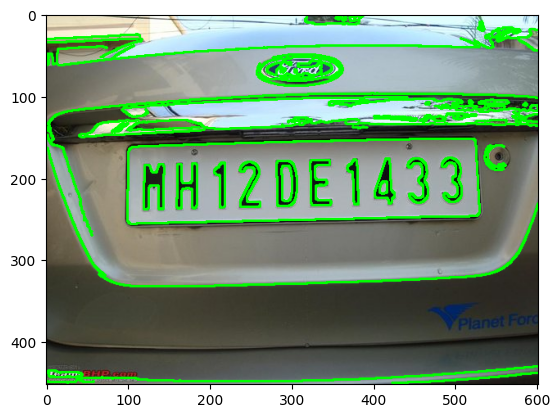

In [7]:
cnts,new = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
image1=image.copy()
cv2.drawContours(image1,cnts,-1,(0,255,0),2)
plt.imshow(image1)

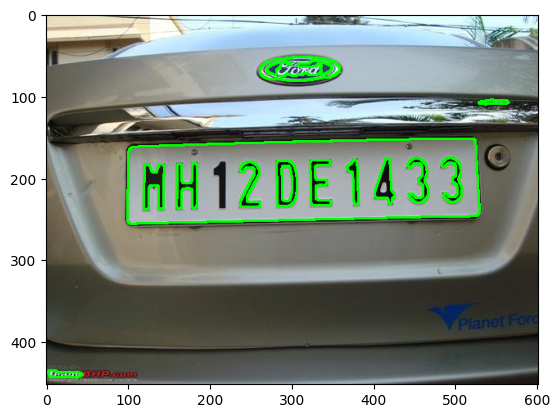

In [8]:
cnts1 = sorted(cnts, key = cv2.contourArea, reverse = True) [:30]
screenCnt = None
image2 = image.copy()
cv2.drawContours(image2,cnts1,-1,(0,255,0),2)
plt.imshow(image2)

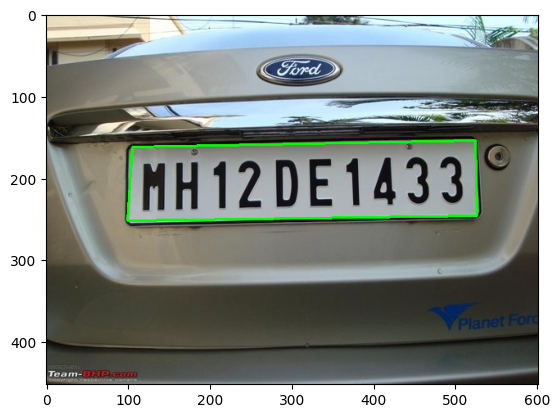

In [9]:
i=7
for c in cnts1:
        perimeter = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c,0.018* perimeter, True)
        if len(approx) == 4: 
                screenCnt = approx
                x,y,w,h = cv2.boundingRect(c) 
                new_img=image[y:y+h,x:x+w]
                #cv2.imwrite('./'+str(i)+'.jpeg',new_img)
                i+=1
                break

image3=image.copy()
cv2.drawContours(image3, [screenCnt], -1, (0, 255, 0), 2)
plt.imshow(image3)

In [10]:
def deskew(im, max_skew=10):
    height, width,channel= im.shape

    # Create a grayscale image and denoise it
    im_gs = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_gs = cv2.fastNlMeansDenoising(im_gs, h=3)

    # Create an inverted B&W copy using Otsu (automatic) thresholding
    im_bw = cv2.threshold(im_gs, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Detect lines in this image. Parameters here mostly arrived at by trial and error.
    lines = cv2.HoughLinesP(
        im_bw, 1, np.pi / 180, 200, minLineLength=width / 12, maxLineGap=width / 150
    )

    # Collect the angles of these lines (in radians)
    angles = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        angles.append(np.arctan2(y2 - y1, x2 - x1))

    # If the majority of our lines are vertical, this is probably a landscape image
    landscape = np.sum([abs(angle) > np.pi / 4 for angle in angles]) > len(angles) / 2

    # Filter the angles to remove outliers based on max_skew
    if landscape:
        angles = [
            angle
            for angle in angles
            if np.deg2rad(90 - max_skew) < abs(angle) < np.deg2rad(90 + max_skew)
        ]
    else:
        angles = [angle for angle in angles if abs(angle) < np.deg2rad(max_skew)]

    if len(angles) < 5:
        # Insufficient data to deskew
        return im

    # Average the angles to a degree offset
    angle_deg = np.rad2deg(np.median(angles))

    # If this is landscape image, rotate the entire canvas appropriately
    if landscape:
        if angle_deg < 0:
            im = cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE)
            angle_deg += 90
        elif angle_deg > 0:
            im = cv2.rotate(im, cv2.ROTATE_90_COUNTERCLOCKWISE)
            angle_deg -= 90

    # Rotate the image by the residual offset
    M = cv2.getRotationMatrix2D((width / 2, height / 2), angle_deg, 1)
    im = cv2.warpAffine(im, M, (width, height), borderMode=cv2.BORDER_REPLICATE)
    return im

In [11]:
final_plate=deskew(new_img)

Number plate is: MH12DE1433



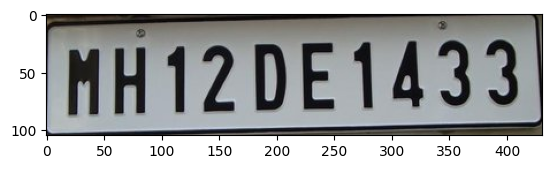

In [12]:
plt.imshow(final_plate)

plate = pytesseract.image_to_string(new_img, lang='eng')
print("Number plate is:", plate)